Dr Oliviero Andreussi, olivieroandreuss@boisestate.edu

Boise State University, Department of Chemistry and Biochemistry

# Fitting and Data Analysis for the UV-Vis Particle in a Box Experiment {-}

Before we start, let us import the main modules that we will need for this lecture. You may see some new modules in the list below, we will add more details in the right sections.

In [29]:
# Import the main modules used in this worksheet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

We need to load the Google Drive and access an example of a dataset from a calorimetry experiment. You can use the same set that I am using by downloading it from Canvas, [here](). Or you can use your own files. I am assuming the file in question will be located in a `ParticleBox_Data/` subfolder in your `Colab Notebook/` folder. I will be using a file named `particleinabox.csv`, make sure to change this name if you use a different file.

In [33]:
# Load the google drive with your files 
#from google.colab import drive
#drive.mount('/content/drive')
# The following needs to be the path of the folder with all your datafile in .csv format
path='/content/drive/MyDrive/Colab Notebooks/ParticleBox_Data/'
path='./ParticleBox_Data/'
file='particleinabox.csv'

The following module needs to be installed on Colab. We won't need it too much for this analysis, but they offer a lot of nice features for chemistry programming. 

In [34]:
# These modules are needed to draw chemical formulas
#!pip install rdkit cirpy
from rdkit import Chem
from rdkit.Chem import Draw
import cirpy

In particular we can use them to draw the molecules in our experiments

In [35]:
data=pd.read_csv(path+file)
data

,cas,p,hasO,hasS,lambda
0,977-96-8,3,0,0,523
1,605-91-4,5,0,0,604
2,4727-49-5,7,0,0,590
3,14187-31-6,7,0,0,707
4,4727-50-8,9,0,0,706
5,18300-31-7,11,0,0,814
6,2197-01-5,3,0,1,424
7,905-97-5,5,0,1,557
8,514-73-8,7,0,1,651
9,3071-70-3,9,0,1,681


If we want to visualize the different molecules used in the experiment, we can convert the CAS codes into smiles and use them to generate the chemical structures

In [36]:
data['smiles']=[ cirpy.resolve( x['cas'],'smiles') for i,x in data.iterrows() ]
# unfortunately one of the molecules is not in the databases and we need to enter the smiles by hand
data.loc[5,'smiles']='[I-].CCN1C=CC(=CC=CC=CC2=CC=[N+](C3=CC=CC=C23)CC)C4=CC=CC=C41'
data

,cas,p,hasO,hasS,lambda,smiles
0,977-96-8,3,0,0,523,[I-].CCN1C(C=Cc2ccccc12)=Cc3ccc4ccccc4[n+]3CC
1,605-91-4,5,0,0,604,[I-].CCN1C(=CC=Cc2ccc3ccccc3[n+]2CC)C=Cc4ccccc14
2,4727-49-5,7,0,0,590,[I-].CCN1C=CC(=Cc2cc[n+](CC)c3ccccc23)c4ccccc14
3,14187-31-6,7,0,0,707,[I-].CCN1C(=CC=CC=Cc2ccc3ccccc3[n+]2CC)C=Cc4cc...
4,4727-50-8,9,0,0,706,[I-].CCN1C=CC(=CC=Cc2cc[n+](CC)c3ccccc23)c4ccc...
5,18300-31-7,11,0,0,814,[I-].CCN1C=CC(=CC=CC=CC2=CC=[N+](C3=CC=CC=C23)...
6,2197-01-5,3,0,1,424,[I-].CCN1\C(Sc2ccccc12)=C\c3sc4ccccc4[n+]3CC
7,905-97-5,5,0,1,557,[I-].CCN1\C(Sc2ccccc12)=C\C=Cc3sc4ccccc4[n+]3CC
8,514-73-8,7,0,1,651,[I-].CCN1\C(Sc2ccccc12)=C/C=C/C=Cc3sc4ccccc4[n...
9,3071-70-3,9,0,1,681,[I-].CCN1\C(Sc2ccccc12)=C\C=C\C=CC=Cc3sc4ccccc...


We can now visualize the molecule that we like

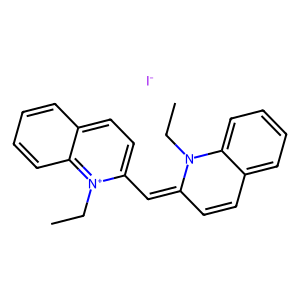

In [37]:
index=0
display(Draw.MolToImage( Chem.MolFromSmiles(data.loc[index,'smiles']), size=(300, 300) ))

In [38]:
def lambda_FE(p,alpha=0.):
    """
    """
    return 63.7*(p+3+alpha)**2/(p+4)

In [39]:
data['lambda_FE']=lambda_FE(data['p'])
data

,cas,p,hasO,hasS,lambda,smiles,lambda_FE
0,977-96-8,3,0,0,523,[I-].CCN1C(C=Cc2ccccc12)=Cc3ccc4ccccc4[n+]3CC,327.600000
1,605-91-4,5,0,0,604,[I-].CCN1C(=CC=Cc2ccc3ccccc3[n+]2CC)C=Cc4ccccc14,452.977778
2,4727-49-5,7,0,0,590,[I-].CCN1C=CC(=Cc2cc[n+](CC)c3ccccc23)c4ccccc14,579.090909
3,14187-31-6,7,0,0,707,[I-].CCN1C(=CC=CC=Cc2ccc3ccccc3[n+]2CC)C=Cc4cc...,579.090909
4,4727-50-8,9,0,0,706,[I-].CCN1C=CC(=CC=Cc2cc[n+](CC)c3ccccc23)c4ccc...,705.600000
5,18300-31-7,11,0,0,814,[I-].CCN1C=CC(=CC=CC=CC2=CC=[N+](C3=CC=CC=C23)...,832.346667
6,2197-01-5,3,0,1,424,[I-].CCN1\C(Sc2ccccc12)=C\c3sc4ccccc4[n+]3CC,327.600000
7,905-97-5,5,0,1,557,[I-].CCN1\C(Sc2ccccc12)=C\C=Cc3sc4ccccc4[n+]3CC,452.977778
8,514-73-8,7,0,1,651,[I-].CCN1\C(Sc2ccccc12)=C/C=C/C=Cc3sc4ccccc4[n...,579.090909
9,3071-70-3,9,0,1,681,[I-].CCN1\C(Sc2ccccc12)=C\C=C\C=CC=Cc3sc4ccccc...,705.600000


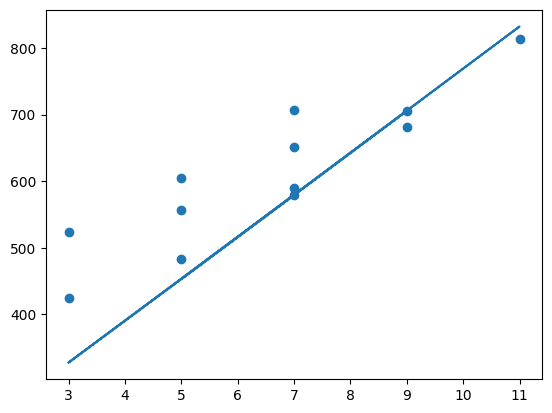

In [41]:
plt.scatter(data['p'],data['lambda'])
plt.plot(data['p'],data['lambda_FE'])

0.521021021021021

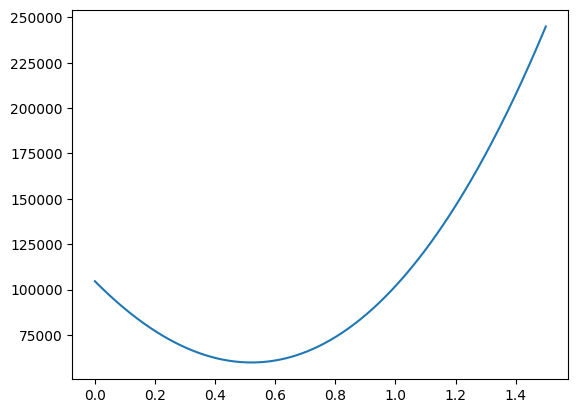

In [48]:
alphas=np.linspace(0,1.5,1000)
errors=[]
for alpha in alphas:
    errors.append(np.sum((lambda_FE(data['p'],alpha)-data['lambda'])**2))
plt.plot(alphas,errors)
alphas[np.argmin(errors)]

In [ ]:
lambda_FE(data['p'],alpha